In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
%matplotlib inline

(420, 580)


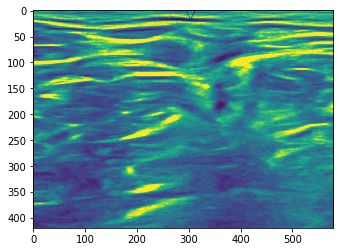

In [3]:
files = os.listdir("ultrasound-nerve-segmentation/train")
im = Image.open("ultrasound-nerve-segmentation/train/"+files[0])
arr = np.asarray(im)
plt.imshow(np.asarray(im))
print(arr.shape)

In [4]:
image_names = []
for f in files:
    if '_mask' not in f:
        image_names.append(os.path.splitext(f)[0])
        
train_names, test_names = train_test_split(image_names, test_size=0.1)

In [5]:
def get_batches(batch_size):
    for i in range(0, len(train_names), batch_size):
        images = []
        labels = []
        for train_name in train_names[i:i+batch_size]:
            im = Image.open("ultrasound-nerve-segmentation/train/"+train_name+".tif")
            lb = Image.open("ultrasound-nerve-segmentation/train/"+train_name+"_mask.tif")
            im_arr = np.asarray(im)
            im_arr = np.stack([im_arr, im_arr, im_arr], axis=2)
            lb_arr = np.array(lb)
#             lb_arr = np.stack([lb, lb, lb], axis=2)
            images.append(im_arr)
            labels.append(lb_arr)
        yield np.array(images), np.array(labels)

In [6]:
sess = tf.Session()
num_classes = 1
correct_label = tf.placeholder(tf.float32, [None, None, None])
learning_rate = tf.placeholder(tf.float32)
# load VGG16 weights
model = tf.saved_model.loader.load(sess, ['vgg16'], "vgg")

graph = tf.get_default_graph()
image_input = graph.get_tensor_by_name("image_input:0")
keep_prob = graph.get_tensor_by_name('keep_prob:0')
layer3 = graph.get_tensor_by_name('layer3_out:0')
layer4 = graph.get_tensor_by_name('layer4_out:0')
layer7 = graph.get_tensor_by_name('layer7_out:0')
    
#     return image_input, keep_prob, layer3, layer4, layer7

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from vgg/variables/variables


In [7]:
# FCN 32
# fcn8 = tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name='fcn8')
# fcn9 = tf.layers.conv2d_transpose(fcn8, filters=num_classes, kernel_size=, strides=32, name='fcn32_out')
# # FCN8 layers

# # fcn9 = tf.layers.conv2d_transpose(fcn8, filters=, kernel_size=2, name='fcn9')
# print(tf.shape(fcn9))

# Apply 1x1 convolution in place of fully connected layer
fcn8 = tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name="fcn8")

# Upsample fcn8 with size depth=(4096?) to match size of layer 4 so that we can add skip connection with 4th layer
fcn9 = tf.layers.conv2d_transpose(fcn8, filters=layer4.get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9")

# Add a skip connection between current final layer fcn8 and 4th layer
fcn9_skip_connected = tf.add(fcn9, layer4, name="fcn9_plus_vgg_layer4")

# Upsample again
fcn10 = tf.layers.conv2d_transpose(fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10_conv2d")

# Add skip connection
fcn10_skip_connected = tf.add(fcn10, layer3, name="fcn10_plus_vgg_layer3")

# Upsample again
fcn11 = tf.layers.conv2d_transpose(fcn10_skip_connected, filters=num_classes,
kernel_size=16, strides=(8, 8), padding='SAME', name="fcn11")

output_layer = fcn11
#     return fcn11

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [8]:
learning_rate = 1e-3
logits = tf.reshape(output_layer, (-1, num_classes), name="fcn_logits")
correct_label_reshaped = tf.reshape(correct_label, (-1, num_classes))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=correct_label_reshaped)
loss_op = tf.reduce_mean(cross_entropy)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op)
#     return loss_op, train_op

In [ ]:
# training
num_epochs = 10
batch_size = 64
keep_prob_val = 0.5

# labels = np.zeros((64,32,32,2))
# images = np.zeros((64,32,32,3))
with tf.Session() as sess:
        # The calls to tf.zeros above do not actually instantiate the values
        # for w1 and w2; the following line tells TensorFlow to instantiate
        # the values of all Tensors (like w1 and w2) that live in the graph.
        print("initializing variables...")
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        for i in range(num_epochs):
            print("Starting Epoch {} ...".format(i + 1))
            total_loss = 0
            for img_batch, lbl_batch in get_batches(batch_size):
                print(img_batch.shape)
                loss, _ = sess.run([loss_op, train_op],
                                  feed_dict={image_input:img_batch, correct_label:lbl_batch})

                total_loss += loss
            print("Loss = {:.3f}".format(total_loss))
            print()
        
#         # Here we actually run the graph, using the feed_dict to pass the
#         # value to bind to the placeholder for x; we ask TensorFlow to compute
#         # the value of the scores Tensor, which it returns as a numpy array.
#         print("running graph...")
#         loss, _ = sess.run([loss_op, train_op], feed_dict={image_input:images, correct_label:labels, keep_prob:keep_prob_val})
#         print(loss.shape)

initializing variables...
Starting Epoch 1 ...
(64, 420, 580, 3)
